In [1]:
# utilization
import os
from tqdm import tqdm
from glob import glob
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data manipulation and visualization tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# cross-validaion and evaluation tools
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, train_test_split

# model development and data preparation
import torch
import torchvision
from create_dataset import *

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SubsetRandomSampler, ConcatDataset
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision import transforms as t


# GradCAM implementations and some utility tools
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, LayerCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

torch.backends.cudnn.benchmark = True

# Prepare the dataset

In [2]:
# image data path
DATAPATH = r'american_bankruptcy.csv'

logging.basicConfig(level=logging.INFO)
df_raw = load_data(DATAPATH)
dataset = create_dataset(df_raw)

INFO:root:Preprocessing data...


KeyboardInterrupt: 

In [7]:
print(df_raw.head())
# ratios_df = df_raw.drop(columns=['status_label'])
ratios_df = ratios_dataframe(df_raw)
ratios_df['test'] = df_raw["X9"] / df_raw["X16"]
print(ratios_df['test'].describe())
# for colunm in ratios_df.columns:
#     if ratios_df[colunm].isnull().any():
#         print(ratios_df[colunm].isnull())
# print(ratios_df['X9/X16'].head())

       X1      X2    X3     X4     X5     X6     X7         X8      X9  \
0   873.1  1354.9  70.8  136.9  563.7   47.7  242.7   842.5112  1662.6   
1   888.5  1422.7  71.0  148.2  601.1   56.5  251.4  1200.3288  1767.6   
2   942.7  1413.2  40.5  126.5  547.9   15.6  203.0  1551.4580  1748.3   
3  1077.4   870.7  82.4  173.3  162.7  -41.9  240.6   705.6420  1456.4   
4   900.2   600.5  66.4   84.7  131.1 -474.3  200.3   805.6440   996.7   

      X10    X11   X12    X13    X14    X15     X16     X17     X18  \
0  1442.1  136.1  66.1  307.7  329.0  637.2  1662.6   576.3  1525.7   
1  1504.1  155.3  77.2  344.9  335.1  688.0  1767.6   589.9  1619.4   
2  1524.7  177.2  86.0  335.1  333.3  701.2  1748.3   588.4  1621.8   
3  1921.0  650.7  90.9  585.7  278.0 -505.6  1456.4  1006.8  1283.1   
4  1343.6  651.0  18.3  396.2  236.0 -979.3   996.7   987.4   912.0   

   status_label  
0             1  
1             1  
2             1  
3             1  
4             1  
count    44906.0
mea

/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/Users/michaelyuan/Desktop/Capstone/Interpretation-DNN/create_dataset.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [3]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    """ Shows random N samples from the dataset """
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        sample = sample.permute(1, 2, 0).reshape(64, 64)
        image = plt.cm.gray(sample)

        axs[0, i].imshow(sample, cmap='gray')
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [4]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

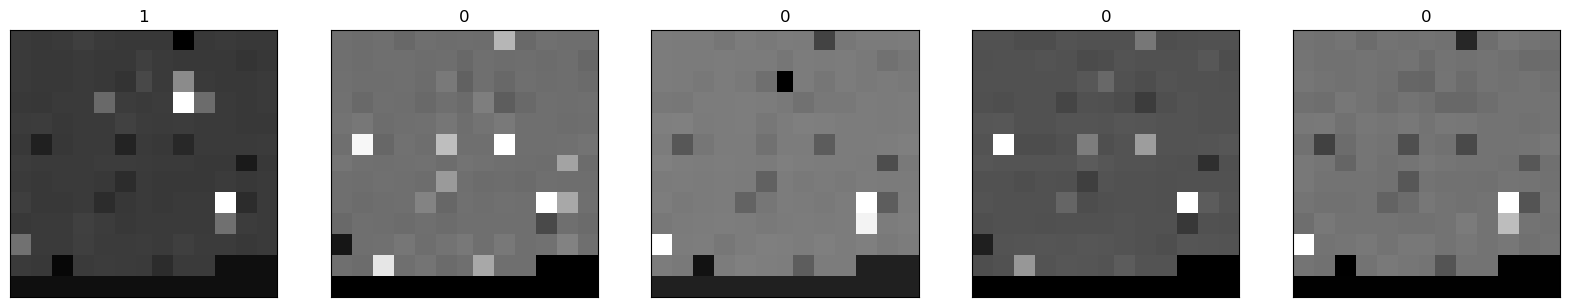

In [21]:
show(train_loader.dataset)
# print(df_raw.head())
# print(dataset[:3])

# Grad-CAM

In [ ]:
### This code is revised but originated from kaggle: https://www.kaggle.com/code/raqhea/visualizing-cnn-activations-gradcam-tutorial

def gradcam(model, gradcam_obj, layers, targets, dataset, N=5, use_cuda=False, show_labels=False, idx_to_label=None, **gradcam_params):
    random_indices = np.random.randint(0, len(dataset), N)
    samples = [dataset[idx][0] for idx in random_indices]
    input_tensor = torch.cat(samples, dim=0)
    
    if show_labels:
        labels = [dataset[idx][1] for idx in random_indices]
        if idx_to_label:
            labels = [idx_to_label[label] for label in labels]
    
    for idx, layer in enumerate(layers):
        target_layers = [layer]
        
        # Construct the CAM object once, and then re-use it on many images.
        # since we will be using it for every single convolutional layer, I will redefine it every time
        cam = gradcam_obj(model=model, target_layers=target_layers, use_cuda=use_cuda)
        
        # You can also pass aug_smooth=True and eigen_smooth=True to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets, **gradcam_params)

        images = [input_tensor[idx].permute(1,2,0).numpy() for idx in range(N)]
        grayscaled_cam = [grayscale_cam[idx,:] for idx in range(N)]
        heatmaps_on_inputs = [show_cam_on_image(img, cam) for img,cam in zip(images, grayscaled_cam)]
        
        viz_img_list = [images, grayscaled_cam, heatmaps_on_inputs]
        subfig_titles = ["Input Images", "Grayscaled Heatmap", "Heatmaps on the Inputs"]
        
        fig = plt.figure(figsize=(20, 10))
        subfigs = fig.subfigures(nrows=3, ncols=1)

        fig.suptitle(f'GradCAM for layer: {idx+1}', fontsize=18, y=1.05)
        for subfig_idx, subfig in enumerate(subfigs):
            subfig.suptitle(subfig_titles[subfig_idx], y=1)
            
            viz_list = viz_img_list[subfig_idx]
            
            axs = subfig.subplots(nrows=1, ncols=N)
            for idx in range(N):
                axs[idx].imshow(viz_list[idx], cmap='gray')
                
                if show_labels:
                    axs[idx].set_title(labels[idx])
                
                axs[idx].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            
        plt.show()

        print('-'*150)
        print("\n\n")